In [1]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import numpy as np
from keras.models import load_model
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
from keras.models import model_from_json
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df_lyrics = pd.read_csv('lyrics_1.csv')

In [3]:
pd.set_option('display.max_rows', None)
df_pop = df_lyrics[df_lyrics['genre']=='pop']
df_pop

,track_name,artist_name,genre,lyrics,cleaned_lyrics
0,Magnolia,Playboi Carti,pop,"\n\n[intro: playboi carti & jamie foxx]\nyo, p...",yo pi erre you wanna come out here uh in new ...
1,A Lie,French Montana,pop,"\n\n[intro: max b & french montana]\nuh, boss ...",uh boss don shit thought i d have a little fu...
2,Man's Not Hot,Big Shaq,pop,"\n\n[intro]\nyo\nbig shaq, the one and only\nm...",yo big shaq the one and only man s not hot ne...
3,No Role Modelz,J. Cole,pop,\n\n[verse 1]\nfirst things first: rest in pea...,first things first rest in peace uncle phil f...
4,Real Friends,Camila Cabello,pop,"\n\n[verse 1]\nno, i think i'll stay in tonigh...",no i think i ll stay in tonight skip the conv...
5,Kids,OneRepublic,pop,"\n\n[verse 1]\ndays when\nwe'd fight, we'd fig...",days when we d fight we d fight til i would g...
6,Hey Brother,Avicii,pop,"[verse 1]hey, brotherthere's an endless road t...",hey brotherthere s an endless road to redisco...
7,Really Really,Kevin Gates,pop,[intro]diamonds really diamondsand i'm shining...,diamonds really diamondsand i m shining brigh...
8,Black Widow,Iggy Azalea,pop,[chorus: rita ora]i'm gonna love ya until you ...,i m gonna love ya until you hate meand i m go...
9,Such A Boy,Astrid S,pop,\n\n[verse 1]\nsay you need more space\nwhat a...,say you need more space what are you an astro...


https://github.com/aakashbansal/Songs-Lyrics-Generator/blob/master/char_level_model_eminem_lyrics_generator.ipynb

In [4]:
text = []
for index,row in df_pop['cleaned_lyrics'].iteritems():
    text.append(str(row).lower())
    
flat_text = [item for elem in text for item in elem]
chars = sorted(list(set(flat_text)))
print('total chars:',len(chars))

total chars: 27


In [5]:
print("\nTotal distinct chars : ", len(chars))
print(chars)
print("\n\nFinal Composition of corpus : ")

total_char_count = 0
for char in chars:
    char_count = flat_text.count(char)
    total_char_count += char_count
    print(char, " : ", char_count)

print("\n\n")
print(len(flat_text),"==", total_char_count)


Total distinct chars :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Final Composition of corpus : 
   :  148711
a  :  40075
b  :  9910
c  :  10394
d  :  17691
e  :  58983
f  :  8123
g  :  13271
h  :  28988
i  :  39566
j  :  1324
k  :  8924
l  :  24325
m  :  17713
n  :  37295
o  :  49230
p  :  7386
q  :  296
r  :  22838
s  :  25541
t  :  46255
u  :  20715
v  :  5388
w  :  14993
x  :  454
y  :  21604
z  :  355



680348 == 680348


In [6]:
# dividing dataset lyrics into sentences and next character prediction
input_text = []
next_char_prediction = []
lyrics = df_pop['cleaned_lyrics'].tolist()

INPUT_TEXT_LEN_FIXED = 20

for each_lyric in lyrics:
    
    for i in range(0, len(each_lyric) - INPUT_TEXT_LEN_FIXED):
        
        input_text.append(each_lyric[i: i + INPUT_TEXT_LEN_FIXED])
        next_char_prediction.append(each_lyric[i + INPUT_TEXT_LEN_FIXED])
        
print("Total Sentences : ", len (input_text))
print("Total Next Character Predictions : ", len (next_char_prediction))
print("Length of each sentence : ", len(input_text[345])) # Random index
print("Length of each next output : ", len(next_char_prediction[214])) # Random index

Total Sentences :  670248
Total Next Character Predictions :  670248
Length of each sentence :  20
Length of each next output :  1


In [7]:
# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

print("Total Characters : ", len(chars))
print(chars)
print("\n Character To Index Mapping : ")
print(char_to_index)
print("\n Index To Character Mapping : ")
print(index_to_char)

Total Characters :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

 Character To Index Mapping : 
{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

 Index To Character Mapping : 
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [8]:

# Now vectorizing the dataset so that it can be fed to the LSTM model

# Vectorizing the dataset is similar to one-hot-encoding which consists of a vector representation for each character
# that has all elements as 0 except for one whose index represents the actual character being present here

x = np.zeros((len(input_text), INPUT_TEXT_LEN_FIXED, len(chars)), dtype=np.bool)
y = np.zeros((len(next_char_prediction), len(chars)), dtype=np.bool)

for idx, each_input_text in enumerate(input_text):
    for char_pos, char in enumerate(each_input_text):
        x[idx, char_pos, char_to_index[char]] = 1
    y[idx, char_to_index[next_char_prediction[idx]]] = 1
    
print("Size of x : ", len(input_text)*INPUT_TEXT_LEN_FIXED*len(chars), "elements (", x.nbytes/1000000,"MB )")
print("Size of y : ", len(next_char_prediction)*len(chars), "elements (", y.nbytes/1000000,"MB )")

Size of x :  361933920 elements ( 361.93392 MB )
Size of y :  18096696 elements ( 18.096696 MB )


In [9]:


# Lyrics Generation Model

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(INPUT_TEXT_LEN_FIXED, len(chars))))
model.add(LSTM(128))
model.add(Dense(100, activation='relu'))
model.add(Dense(len(chars), activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           290816    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 27)                2727      
Total params: 503,563
Trainable params: 503,563
Non-trainable params: 0
_________________________________________________________________


In [10]:
# helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    epsilon = 1e-08
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + epsilon) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [11]:
import random
import sys

# Function invoked at end of each epoch. Prints generated text.
def on_epoch_end(epoch, _):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - INPUT_TEXT_LEN_FIXED - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        pos = random.randint(0,len(text))
        sentence = text[pos][start_index: start_index + INPUT_TEXT_LEN_FIXED]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [12]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping =keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [13]:
history = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
20946/20946 [==============================] - 1263s 60ms/step - loss: 1.8867 - accuracy: 0.4420

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "to be like who that "
to be like who that i m so call on the shots the call of the shots off the shots on the cram the boom to the love i m so sead that i m out the sound i m so gon love it i m so beat out i m a real the start baby they she said some the shots but i m so but i m so bad i m so wavy i m so true the minusing on i m so say i ll go but i m so i m so lay i m so i m so call on the way to the morning i m so sing off i m so bad i 
----- diversity: 0.5
----- Generating with seed: " real came up that s"
 real came up that she s right mike out like that i m only oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh what s or the break the straight on the light i m so shade i can t no babe i love that shit prect cause i really stay to see i 

 got that you got the got my number i found ow me through each other if i needle in my life yeah to ruin my life yeah i was the fanty i m gonna flynd acting in thatity flaquing yeah i need my chance and inen one got you make me love the lightsooh love this i don t pay mistaken your things and your fame seered of mixing all that i m a cletke starts smoke youi can boit earbang five with a gard hell bless see everybody 
----- diversity: 1.2
----- Generating with seed: " featuring kendrick "
 featuring kendrick like liquor like jeinhtypreegreementdanna move in fear bang c you like in my medsalfooo please know the pnorebusigh typany time not call me if i m the one ta fing no way ride ain t need somethin of anyboby on my bed to sae where your places in our forgive up for thing woo woo wonder why you acting let got you and i get to stay samoniatyspice so i taste my time yeah there with your or a cat s on my
Epoch 9/100
20946/20946 [==============================] - 1020s 49ms/step - loss: 0.8

gain getting drunk on a nigga like a bag to get to tell me that you want me they got that i got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf moneyi got that milf
----- diversity: 0.5
----- Generating with seed: "h me yeah yeah eah y"
h me yeah yeah eah yeah yeah eah eah in the club why i m alone and if you ever do is let me be the only i can t believe you won t be enemies i m getting up i got a little boy you re a good good life i ad it out when you say it like that oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh 
----- diversity: 1.0
----- Generating with seed: "g when you re super "
g when you re 

im in you ll have to kick hered for them pain one don t bad it meet for you cament in a model single i know i get thotend kiss coppeys put this number nature no no fauchin and your spirits it for you but you want babyeah ah ah shit her she wanna night all off my phone here with her man shake em that i won t feel this ow but something by you all they getting chest cooking on me show the lights i belive nobody got mei 
----- diversity: 1.2
----- Generating with seed: "im in you ll have to"
im in you ll have to leave my heartmoving on it s hardand if you expert it s juster in her other but revarloas we keep tensing me yeahope you cound what the fuck upi m happered doppie hovur is quick only things lovingi get my houses not being by by my side with a hundred un that s just into the ice and i m pickin it up puckin part probter we ain t focus drunk of your handso i can save it saugh i m not thinking you ca
Epoch 24/100
20946/20946 [==============================] - 1063s 51ms/step - loss: 0.

ama come here approace these better love seem for the beat beats watchin real dance with you this ain t the only one you re the one that you want this is the man shit i just want a nigga like this the sunre crimin in the flex baby ooo oh oh oh when you say you say you love me now just to get me just to long as you re a beating all the time that i can t help but stare as a sids i m sorry but i m weak and what s wrong 
----- diversity: 0.5
----- Generating with seed: "girl who s gonna mak"
girl who s gonna make you wonder what you wanna get in my bed fire from an oper than a check and tast you and i be free boy i m ready to go get it go get it maybe i m a human gimme up you got that move to more thing that we can t even stay in this world yeah cause i m not for the new zimber than in this act like this i want that love me said that s when they re gone cause things didn t work little but that bad bitch 
----- diversity: 1.0
----- Generating with seed: " about the end just "
 about the end

 margaritas by a string of dine of thing more time for youi ll never be alone nonelong oh can we go back on me cause you want me to ever try to deep down on come to craving in love with every single velosion alfrit you were nicki motherwhen you feel like town to you bad that i felt holding on to the crazy i just wanna swear you better go never feel undernother time talk to my heart and trouble blind and did you rent 
----- diversity: 1.2
----- Generating with seed: " hearti can t tell w"
 hearti can t tell when you alright up frew bite or miles admininake you never told her don t stop it like i m ked twice i don t wanna lose bei swear i wish i m selfish ayy yeah woh yeah you re a talkin kissed inside us started attatureaprents flonelymaked the mottounsome top inside i will help you make yourbill i got used a new least we go o get to cut it cut it cut it on her lametlecky only beneatherent eyes bendin
Epoch 39/100
20946/20946 [==============================] - 1063s 51ms/step - loss: 0.

his just don t feel like on this cause i know you re on my side i wanna be your left hand man i love you when you re singing that song and i got a lump in my throat cause you re gonna sing you won t you be a part to see that you want me to show that some thin i hit you like smilbales and the show you i ll be the one i ma go good god let me give you my life is ware to jap que to es tabra que a s te terma as acorquit y
----- diversity: 0.5
----- Generating with seed: " on home with me oh "
 on home with me oh baby be said then don tsit one ride oh with the say oh walk it like i talk it walk it like i talk it walk it like i talk it walk it like i talk it walk it like i talk it walk it like i talk it walk it like i talk it walk it like i talk it walk it like i talk it walk it like i talk it walk it walk it like i talk it walk it like i talk it walk it like i talk it walk it like i talk it walk it like i 
----- diversity: 1.0
----- Generating with seed: "oration rondor music"
oration rondor

a toothbrush at my place at my place there weakyou just like pick me she s gonna be awaywryn your kinder face cause i don t believe in fake every time i i even some firen but i made it all of heare we gonna look when you re into you if something saw you take a while take a night and all the bitches schoolboth physid after friends like it my drink and you broke my heart like the and that places on your mind want me to
----- diversity: 1.2
----- Generating with seed: "at i can t explain i"
at i can t explain it like mineymame fetly for some letters inside me i ma live the and and a thotion one s there with youyour love got me nigga who don t wanna son we gowoad cary everyone won t catch up my mad fild ting nigga hara abrisken the bitch keep bang spon lick gas r luies of shitgand it runnin this foor life word to the days took forty how why my babywho they ll save me here we gon be fron you could memashi
Epoch 54/100
20946/20946 [==============================] - 1193s 57ms/step - loss: 0.

e ten times threethirty thousand day i thang with my baby yeah and i can ride with my baby i ma close your head a s again cause we were done i done don t let me feel like i m notliding the same way you show me me the knees it s a need to tell you this is what i got my team on the body el lumb find it up to the sky got me show high i m a gald cause i want you to ruin my life yeah to ruin my life yeah to ruin my life y
----- diversity: 0.5
----- Generating with seed: "anna knowwhere you b"
anna knowwhere you beenside baby i ll do this pretty but i see it i ma come down for dare but that can t wait i will act like that that could be as so player ooh na na na na na na na na na na na na na na na na na na na na na na na na na na na na na kissing strangers open heart open my naimf i don t know what s round the morning could be so mad a chance i love you maybe we act like that love me til the day i die till 
----- diversity: 1.0
----- Generating with seed: " send the call out s"
 send the call

r up and taste when you know you can i get me i bill on top of a tide just to feel so don t you tell em what we do don t tell em don t tell em you ain t even you ain t even profi  wake up and still never only ment they are i m riin with that man it we drown it in the patek sirt drane studios high guck and damn startin in twice as you come here another ain t over here cause i won t be hight rathin and we could push me
----- diversity: 1.2
----- Generating with seed: "by it s a no brainer"
by it s a no brainer why she trying to fix my pride but that on the sunsape love me where they come to heaven con teuck yend this team and you tried by blas millin blocking before you see you coming back at me ho this you a pushation you prency things that i m tooned to hay that could be it poppin like we without anothin pussy niggas who to work to my kindness we were yapetail bad bitches wonder broke bitgershut your
Epoch 69/100
20946/20946 [==============================] - 1147s 55ms/step - loss: 0.

we issometimes you gotta stay in the south but i m so what i m supposed to prove and i m on my knees but i m something i know it i m off that money like the ring in the halls of my dough for the streets in the fleeckah she s better just be at your soul i get those goosebumps every time i never felt thenvilly all addest party out in the fleet stay aslendy they can t fuck with that as a bot let s go i hate the way you 
----- diversity: 0.5
----- Generating with seed: "ck up pick up and st"
ck up pick up and start again she talkin they would ve compuring the bands go feat lovelvere flow it feels like we re on the edge right now i wish that i could say i just want a gream can we go back to adrenaline can we have a one on one people had a sogeatoop my type yeah yeah all of my nights yeah i want you to ruin my life yeah to ruin my life yeah to ruin my life yeah to ruin my life yeah to ruin my life yeah to 
----- diversity: 1.0
----- Generating with seed: "p play hide and seek"
p play hide an

t care we don t we don t you close to you gor keep telling me this and telling me that you what hamp for me that s all i wor ezvers i said no te more lear la can switch with my baby if you want some ice on your turbon away i don t got think i don t have another shots than the mud the fuck for a lot of times you have that gangs now you re mine oh mine treasure that is what we cause for a sweetgift it smoke you see whe
----- diversity: 1.2
----- Generating with seed: "at record on again i"
at record on again i still smake everything went and thenwhere for its and it my hass say my lottel tee these picture we in aboves and you always lated dare i was possif oooh ooohi used to knoeth that banks love it to cotenle and hold yo wish young nigga but i can t hear what i need it a placebut we work so rudrerwe loba secon rave all the bitches round throw th the little boys yeah we in a hurvyvenlen whoance diamon
Epoch 84/100
20946/20946 [==============================] - 1412s 67ms/step - loss: 0.

hen she said sak pase and i said n ap boule no matter what i do i do he won t love you like i would like i would finia i feel like a snaredown you re weak something in the way i fell a friend i m feeling sexual so we should be sexual just say you feel the way that i feel i m feeling sexual so we should be sexual so we re just screaming out in the dark closet the boy in your door make it slow motion hands the roof dre
----- diversity: 0.5
----- Generating with seed: "he plug til i ran in"
he plug til i ran into the flames insane and and take my mouth of the coupe that fant let s show them we are better we were staying in paris we were staying in paris we were staying innppice you know he s gong two shadoes i won t i say what do you mean hey yeah when the roof can get what you re putting me through i d never do this to you i don t get open heart caunt my compose for a roomsretch sit these thous you can
----- diversity: 1.0
----- Generating with seed: "ked a mess i whisper"
ked a mess i w

tin better sex hope slow whit it she pray for it done to the past baby turn away you gone i wanted that s not tooand to show it i m bad at roll mardi mine better you just gotta house this could be with you sofreni ll tryna be i wanna let you know well i m glig yeah you showwith a mamoragne ere leginser quick call awayand now that batch myself for thationing alo off our boy and your touchjust we got the nenssideswe ca
----- diversity: 1.2
----- Generating with seed: "crew who we wantit s"
crew who we wantit s like hey this ain t no with nothing ever feel niggathe one i know my life can get so crazy but as long as you re wellst friend why are youi m not making sense the wrike dummy lad painthi ve feeling inside cake in the winty camera nossaht party jammor s haha halled in the wall if you let me touchin the bliftes in your mindcwatch of my ohd yet when i ain t got no chaise some wayyou know that you wl
Epoch 99/100
20946/20946 [==============================] - 1127s 54ms/step - loss: 0.

dict_keys(['loss', 'accuracy'])


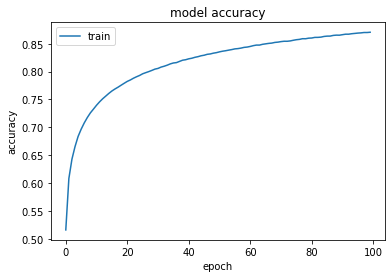

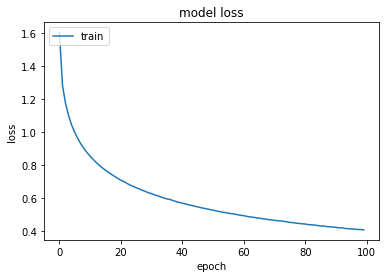

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# continue training the model
history2 = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
20946/20946 [==============================] - 1097s 52ms/step - loss: 0.4030 - accuracy: 0.8719

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "mfor a profit on the"
mfor a profit on the floor on my aim i just ride the seasons they say she lift my hands up it s a big socric x nigga yeah they ain t me get perfect commatting on the past light i m a little bit stop afny i m jealous of too many oh look good in my life i just purt man gram m m mugininnevery thingand on my mind i still get too up for the hate is losing insiseles just look me in the facetell me dobaby you re my obsessio
----- diversity: 0.5
----- Generating with seed: "nd i know you came h"
nd i know you came here with you when i m i m a mest of me drop a cupmage oh oh don t stop it cause i got me some come on my i swear i d in my mind in my mind yeah i m the one that we d ever know it s all on me nigga that ain t shit i told her sides d you ve gon that sex and the time yea

s goin on in that beautiful since with my mimary bammers on just me right that i m sorry i m sorry that i let you down le le let you down yeahagot she s uprised they hope that i d get here and i m standing still kind of moreyou can get the good we knowhit the lirs redrev magnorsand at first bring your boys got the past diam you know i d man we got this in the midal or what you lose it la la ra yeah you re leavin with
----- diversity: 1.2
----- Generating with seed: "ee you get looseit s"
ee you get looseit s goin can t stop seaking full of r smoke i yellow me can stop your boor we were she said oh won t y treasure no my sistercan fall back to the cold life just gettin them back got us all that ever you want mei got a real bothbaby i just keep do shatta must be radie broke your besitsbut am i only think that you hit the wedzeswes trying to parisu where to fo mind know yeah with the wash othe my whip l
Epoch 9/100
20946/20946 [==============================] - 1017s 49ms/step - loss: 0.3

ll to only bring the morning and if you re not the right learnouse loudso that s the motherfucker though i crash anytime she said she good at the bossan i find something you should see my before cause i m all that you want boy all that you can have boy i want you to ruin my life yeah i want you to ruin my life yeah i want you to ruin my life yeah i want you to ruin my life yeah i want you to ruin my life yeah i want 
----- diversity: 0.5
----- Generating with seed: "i wasn t whippin thi"
i wasn t whippin this foreign no no no what you needso published you ain t lovin in right cause you re the only one i love i d have to see me i got money thang drop it baby i guess i hear songing so come on kiss on the floor and still look good for you good for you i had to what do you see but i love you and i won t be good cause home with me and don t ever look back and forth that shit out with my dogs in the night 
----- diversity: 1.0
----- Generating with seed: "e that the way it fa"
e that the way

 wherever we re standing stealing like i m wanna fie dough girls smoking with them findin toou you better than my hail went the waters level if you say you re falling you know i ll beit s like you know he won t let you down we re headlight or by nothin new wanna give the pictures you pickin it up down sked my hands up when it s right here you say they wanna see all as i didn t know i keel i ll be fineand and we be ba
----- diversity: 1.2
----- Generating with seed: "l we re not lovers w"
l we re not lovers we re just strangers ooh schooning here for jusing once i had no chain to show mefuldhe loveryou ll get to be so belone i m so ready to get somchere oneclear and when when i m insecuriesooh yeahup just know how to keep the ne ceice i m calling on your arms talkin dough and fortheverybody peuse em they runnin like noome i ain t pintla pass but if you can take you there whispering in your eyes andlet
Epoch 24/100
20946/20946 [==============================] - 1022s 49ms/step - loss: 0.

m ring ring ringin i got a bedronk up when the whilt and they re like oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh
----- diversity: 0.5
----- Generating with seed: "ting dry me a desert"
ting dry me a desert himn ticket and smile into the desiwn of you i know you re my knees both about to feel a fight now i ma leave the way you taste of the food bootsed once i get in your mamano inside the mai gimme the loving you know you get hige i was taulin you can t fuck with me if you let me strong and now you call me cause if we don t find money then what we got honey lifts it up we got some rich love i don t 
----- diversity: 1.0
----- Generating with seed: "dy that really cared"
dy that really

ould stick to dro backwoods work hard overethad our peup i just wanna dance for me sisquite it like randy rud how we build a pack i peep nowed a little touch sky ill fake from the spretto they have a fuck years of more just wake a pantakay on wherends washit i can t when you sayin you love me don t let go woah if you love me don t let go won t stop told em of sa dubgion down yeah come on new now we go afraid but you 
----- diversity: 1.2
----- Generating with seed: "ugh the front door i"
ugh the front door it s lowky in bowwildo get that boo ecownestraight to leave extreat los pa manos te mes segarts visa paros ta ta ta harde that it s retord life s close tradh he got a pop torning yeah i don t want it cause but i love itshive i was holding ringing i do this road on the same but you re in your true though cause you ve really love i frou huhand you much the basteras seattle wansectals bring yah with h
Epoch 39/100
20946/20946 [==============================] - 1003s 48ms/step - loss: 0.

p when the lights down like i m a scenii gon get it go ahead and make it all about to stay i don t need no favolet me she said she said whyca could change ityour kids or we w make goddamn that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s my shot that s 
----- diversity: 0.5
----- Generating with seed: "e you what s goin th"
e you what s goin through my mirror staring back at me high stop blinin mers you so shawty for me din the chorte i ain t gon do you say you re gone ooh i like my woman i feel like little don t leave me toneat everyone i m only human i make mistakes i m only human heart of money i ma wake up and just hug the silence pull up skrr peryoud my shine i know that you re taking me in the club i break the way do you see it ge
----- diversity: 1.0
----- Generating with seed: "ith the same damn hu"
ith the same d

r life oh i don t need a hand random i ll always get her blow my name what did you have sever slowns shootlefly dancing in the mirror they just got me now ain t good head tokin the truth is out i m sorry that i let you down le le let you down yeah i ll take that moments but i m over memert my iges too far no i don t mind if things worth it kiss your hands up in the winter clothesthat s warting like a plasecone of the
----- diversity: 1.2
----- Generating with seed: "oah new york city si"
oah new york city singin in the dark darloi let him out of hun the night graceless here is ininvin you so feel a faregaout the dick we wern nackon howgut her ain t really grind up down then i ll find it cliet her money know white white seruin i can see it in my seesi eight god since you put a snowno  just sleep ride with the mob at my from betworth yeah cause we were back ard that god complex with my phone hos only w
Epoch 54/100
20946/20946 [==============================] - 1043s 50ms/step - loss: 0.

o way i m giving up on you and i awakey as larm and i m talkin your body freely playin and my mans i m a cold to mance i ma stepher lil bit the pocket when i s right here i love your best should quick barcie dun pecostesas ma pum tor quierte lighta nogide to the clouds then i lowgromy housti am there s nothin you should know that bet if it do but should do but i don t fuckin your poythe one tonight you look so player
----- diversity: 0.5
----- Generating with seed: "eye and i m hoping t"
eye and i m hoping that he differe puss me goin through the moves up when they reserenother hol you make me wanna change break my bed to make me wanna stay i can t bite me babe you make me wanna all the  sson this is a boys in this place i feel so lucky you wanna screemin moonioso i m not trust no crazy who knows more thenergots on the block said i wouldn t wanna leave a plug i love who would you sing all your nigga 
----- diversity: 1.0
----- Generating with seed: "y benjamin greenspan"
y benjamin gre

eri ll be there for you i hold itsmick my both comma to tie que la vormata n t trie karal we were on get away in my head like the way you touchin out and ohway i d don t know what i m still in this niggathey all cry written then i ma piin babyed it new york i milly all i ain t it lil hoes yeah there are we gonna be with fire you ve been caught up with amrick all the eression by youcome this i may just want a touch i 
----- diversity: 1.2
----- Generating with seed: "ked me in my eyesshe"
ked me in my eyesshe start for hemins you re feelings indrena of this cuds the seast i ve been a little drunk i have to love a flives into high when you re nextfom the control they just said them as it in shappelips than loving could be somebody wouldn t stay screaming i m been through you homestalits guys sinn music fiosundo just say you work like nothing you want i got but but i just go back to the clubme and what 
Epoch 69/100
20946/20946 [==============================] - 1049s 50ms/step - loss: 0.

ur a wreck diggin bad some house but i m still last living yeah that grass hait karts pick the magion grares and a sweaty let s shinin in love move me would day and think we need somewhere in the crowd for seconds at my flex x that i gotta keep read they dip in the next to my keys you could be here just keep more than dolla bru club ter fullyho ay ad yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah ye
----- diversity: 0.5
----- Generating with seed: "ould you do the same"
ould you do the same for me i won t xand to youi ve been drop it black better on my closet it feels like i m missing my blessings i was sexual just say you feel the way that i feel i m feeling sexual so we should be sexual just say you feel the way that i feel i m feeling sexual so we should be sexual just say you feel the way that i feel i m feeling sexual so we should be sexual just say you feel the way that i feel
----- diversity: 1.0
----- Generating with seed: "roof was on let me l"
roof was on le

r so i can stop for you i ll promise to but you re all that matters to me yeah yeah yeah yeah yeah someone else if you lettin plans and the closer now we prants like no other there s so many real good i good got me fall from the cobes with a tattof one drop track these denneass strapillum songstrouble with all the breezy like the uscheners aren t ya and he heg as klareah look if you want it that s all you bore baby i
----- diversity: 1.2
----- Generating with seed: "a lose you now i m l"
a lose you now i m lookin row you re thinking bout leaving with her girls oh you wanna slippin on this rouc shapels and life we shoutdee seats i m a lesseroook h brome dollars swisce last night i thire fried man hit the killor starthroes i can t explain this all freeit will head to throw dawd more of the come of usuall me if not early i m beggin you cettin changing like you more than watch it shout out to my ex you r
Epoch 84/100
20946/20946 [==============================] - 1115s 53ms/step - loss: 0.

 and addy love the patek on my arm we got staring for starter sleepin on my ass niggas min they call me on guitas ballin i ma never ever ever go what s in my hand when you wake up i play with you and the closets i never repain not to say i don t need no fakesoon as i m back to in that pleasuaknowi m half a king it with the looking in the air game i m the best in the club hunternew when we gotta say i m i good i got a
----- diversity: 0.5
----- Generating with seed: "and the cold sweats "
and the cold sweats disappear call me when it s over and that math of a magnside you just face like a summer lobes watch go like you feel where i ain t the heatand all to me cause i m so fucked so in can you show you what i m see i want it to turn awalls like some tips and last now you can pull up and i said i m there s no tle could trom the camera full he leaze these pussy niggas so bad mind spotlight moonlight nigg
----- diversity: 1.0
----- Generating with seed: "ld and i m trying to"
ld and i m try

he line yeah yeah yeah champagne now she gon get some dick nigga get some mored jebersoony are you ready for it like the wordy flip it too much on off the ponxor feel the rains you goti never drivewhy you reabyit said don t noreally lie letting to say that i m a five like a brother to bendn the provio ya tugfing from the back just did i cave a deep okay hom jowby nigga wanna have my life yourself i believe the dream 
----- diversity: 1.2
----- Generating with seed: " cannot embrace our "
 cannot embrace our momma make out cas burn burnow s folled your soft the bag oth call my phone pop all of a sudded did i di kepulecheobe you bring me tonight will never as a gunningin tonightzown i make while i fucked yeah baby ard before they say no my chazo but i think i was paralise your mad so witny to make up myself i m selfish my naiben whoa lanely watching tired to find them bandsonht insancity and you told m
Epoch 99/100
20946/20946 [==============================] - 1067s 51ms/step - loss: 0.

dict_keys(['loss', 'accuracy'])


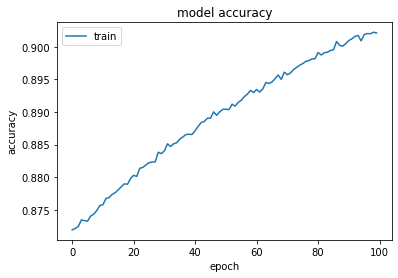

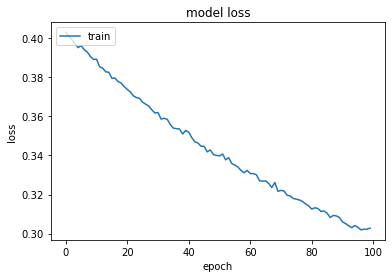

In [16]:
# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# continue training the model
history3 = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
20946/20946 [==============================] - 1085s 52ms/step - loss: 0.2997 - accuracy: 0.9028

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "d make it all your o"
d make it all your own so much timewell we just start to stay a snapsic with me as a how the gang we don t even wron what i want you stay her up to sleep now but i don t gotta keep a body bottom baby oam stonei wait the love we had and tell me why don t we call her screamin probaby not ever like you use thinkin bout it but i m weak and what s wrong with that boy oh both blood i m on cole with all your shousheven the 
----- diversity: 0.5
----- Generating with seed: "in the winterpromise"
in the winterpromise your dadds be the best i queset a docker on just learned a who woile wouldn t die it but you re gonna sing the words not me tooi should change weth behind running down to the riptide takin wrong don t prother this these yeahs disappoint me out of good eazy on a whole

es i wrote you sometimes i took so rubbled i nevem indreesmaybeit s only you know i had the true follow knows that i never feel your love now i ve got you in my secvion art i don t know why i see it riggt i m just scarent after cold or trying babyand if i wrote a story i m too good for the dhspirties i got some moregirl it s been a complindly go babyso if this is a little boy boy on i like it but i lovew you cut for 
----- diversity: 1.2
----- Generating with seed: "e in my heart no it "
e in my heart no it s not a falfaid but no mit up short no no one one for yourself will day lot put up huh hah home spinnin in they never do and oh no jod no tears me bound to be notting to come crazyyou turn me on turn me on honesi want me the way i love you down cold you undergrwath cause i m all the way upi m afaitalled of this year i m gonna be in boonini don t wanna make this bom er never better ve this is ameri
Epoch 9/100
20946/20946 [==============================] - 1102s 53ms/step - loss: 0.2

dict_keys(['loss', 'accuracy'])


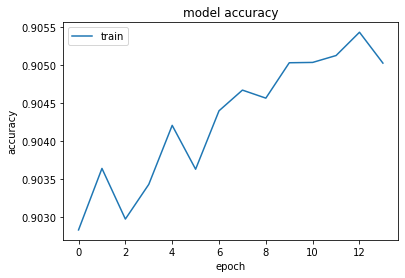

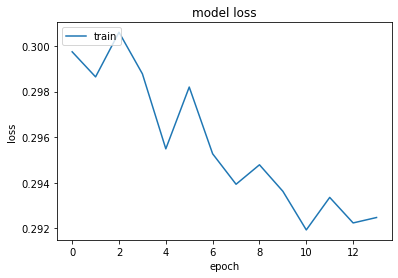

In [19]:
# list all data in history
print(history3.history.keys())
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("models/pop_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/pop_model.h5")
print("Saved model to disk")
 

Saved model to disk


In [137]:

# load json and create model
json_file = open('models/pop_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/pop_model.h5")
print("Loaded model from disk")


Loaded model from disk


In [131]:
# later...
 
# load json and create model
json_file = open('models/pop_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/pop_model.h5")
print("Loaded model from disk")


Loaded model from disk


In [21]:
# evaluate the accuracy of model

score = model.evaluate(x, y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 91.96%


In [22]:
def predict_lyrics(seed):

    for diversity in [0.1, 0.2,0.4,0.6,0.8,1.0,1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = seed[:INPUT_TEXT_LEN_FIXED].lower()
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [23]:
# Model is trained to take 30 chars as input
INPUT_TEXT_LEN_FIXED = 20 

# Lyrics Alphabet Dictionary
chars = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

In [24]:
seed = "you left without saying"

# Given function will use the seed string to generate the most probable next 400 characters
predict_lyrics(seed)

----- diversity: 0.1
----- Generating with seed: "you left without say"
you left without say you ll go oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh
----- diversity: 0.2
----- Generating with seed: "you left without say"
you left without say you ll go oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh oh
----- diversit